# Goal

1. Look at distribution of editors by activity to create a calssification of 
1. Needed columns. 
  + lang
  + userid
  + reg_date
  + First edit date
  + Last edit date
  + active?
  + bucket?
2. Get random-sample edtis from within each bucket and ORESify
3. Produce protopye data for thanking app, 
  + we can test with liasons to see what kind of threshold theres is for thankablity with regards to ORES scores

In [1]:
%%capture
!pip install mwclient
!pip install mwviews
!pip install mwapi

In [2]:
from itertools import islice

def window_seq(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result
        
def wmftimestamp(bytestring):
    if bytestring:
        s = bytestring.decode('utf-8')
        return dt.strptime(s, '%Y%m%d%H%M%S')
    else:
        return bytestring
    

def decode_or_nouser(b):
    return b.decode('utf-8') if b else '#nosuchuser'

!mkdir outputs
!mkdir checkpoints


import json
import requests

from sqlalchemy import create_engine
from sqlalchemy.exc import ProgrammingError
from pymysql.err import InternalError, OperationalError
import sys, os
import pandas as pd
import numpy as np

import mwclient
import mwviews
import mwapi

from datetime import datetime as dt
from datetime import timedelta as td

%pylab inline

langs = ['ar', 'fa', 'pl']
langsde = langs + ['de']

langcode = langs[0]

datadir = os.path.join('data', langcode)


site = mwclient.Site(('https', f'{langcode}.wikipedia.org'), path = '/w/')

os.makedirs(datadir, exist_ok=True)

constr = 'mysql+pymysql://{user}:{pwd}@{host}/DB?charset=utf8'.format(user=os.environ['MYSQL_USERNAME'],
                                                      pwd=os.environ['MYSQL_PASSWORD'],
                                                      host=os.environ['MYSQL_HOST'])

con = create_engine(constr, encoding='utf-8')


con.execute(f'use enwiki_p;')


#Tuesday Mar 6 2018
#Friday March 23 2018

sim_treatment_dates = (dt(2018,3,6), dt(2018,3, 23))
sim_treatment_date = sim_treatment_dates[0]

sim_experiment_end_date = sim_treatment_date + td(days=90)
sim_observation_start_date = sim_treatment_date - td(days=90)



mkdir: cannot create directory ‘outputs’: File exists
mkdir: cannot create directory ‘checkpoints’: File exists
Populating the interactive namespace from numpy and matplotlib


In [3]:

import mwreverts.api
import mwapi

# We'll use the mwreverts API check.  In order to do that, we need an API session
de_session = mwapi.Session("https://de.wikipedia.org", 
                        user_agent="Max Klein Newcomer Quality <max@notconfusing.com>")

# for a single user, get their revisions and determine how many are flagged or not

def get_revisions_and_flagged_data(user_id, treatment_date):
    rev_flag_sql = """
        select rev_id, 
                rev_page, 
                page_namespace, 
                rev_timestamp, 
                fr_timestamp, 
                (select max(fr_timestamp) from flaggedrevs where fr_page_id=rev_page and fr_timestamp < {treatment_date}) max_fr_ts 
            from (
                  select rev_id, rev_page, rev_timestamp, page_namespace from revision_userindex
                    join page on page_id = rev_page where rev_user={user_id} 
                    and rev_timestamp < {treatment_date}
                    order by rev_timestamp desc limit 500) auser
            left join flaggedrevs on
                fr_page_id = rev_page and
                fr_rev_id = rev_id;
                    """.format(user_id=user_id, treatment_date=treatment_date.strftime('%Y%m%d%H%M%S'))
    con.execute('use dewiki_p;')
    rev_flag = pd.read_sql(rev_flag_sql, con)
    rev_flag['fr_timestamp'] = rev_flag['fr_timestamp'].apply(wmftimestamp)
    rev_flag['max_fr_ts'] = rev_flag['max_fr_ts'].apply(wmftimestamp)
    rev_flag['rev_timestamp'] = rev_flag['rev_timestamp'].apply(wmftimestamp)
    return rev_flag

def was_reverted(rev_id):
    try:
        _, reverted, reverted_to = mwreverts.api.check(
            de_session, rev_id, radius=3,  # most reverts within 5 edits
            window=48*60*60,  # 2 days
            rvprop={'user', 'ids'})  # Some properties we'll make use of
        return True if reverted else False
    except (KeyError, mwapi.session.APIError) as err:
        print('Error getting revert status for {rev_id}'.format(rev_id=rev_id))
        return True #because even if it was deleted from the DB for our purposes its still a bad edit 

def decide_flagged(row):
    """Was this revision flagged (or generally high quality)?"""
    namespace = row['page_namespace']
    rev_time = row['rev_timestamp']
    flagged_time = row['fr_timestamp']
    last_flagged_time = row['max_fr_ts']
    was_reverted = row['was_reverted']
    
    #namespace check
    if namespace != 0:
        return True # because often user-page edits are never approved   
    # check if explictly flagged
    elif pd.notnull(flagged_time):
        return True
    #check if reverted
    elif was_reverted:
        return False
    #check if the last flagged time is after the edit
    elif last_flagged_time:
        if rev_time < last_flagged_time:
            return True
        #the revision exists but it hasn't been flagged yet.
        else:
            return False
    else:
        #not sure what else would get to this stage , but...
        return False
        
def get_flagged_decision_df(user_id, treatment_date):
    rev_df = get_revisions_and_flagged_data(user_id, treatment_date)
    rev_df['was_reverted'] = rev_df.apply(lambda row: was_reverted(row['rev_id']) if pd.isnull(row['fr_timestamp']) else 'no_check', axis=1)
    rev_df['flagged'] = rev_df.apply(decide_flagged, axis=1)
    return rev_df


def get_flagged_revs(user_id, treatment_date, return_all=False):
    needed_columns = ['user_id', 'rev_id', 'rev_timestamp','was_flagged', 'was_reverted']
    rev_df = get_flagged_decision_df(user_id, treatment_date)
    rev_df['user_id'] = user_id
    rev_df['was_flagged'] = rev_df.apply(decide_flagged, axis=1)
    if return_all:
        return rev_df
    #limit to only flagged
    rev_df = rev_df[rev_df['was_flagged']==True]
    # limit ot non-talk pages
    rev_df = rev_df[rev_df['page_namespace'].apply(lambda ns: ns%2==0)]
    # Limit to 17
    if rev_df.empty:
        return pd.DataFrame(columns=needed_columns)
    rev_df = rev_df.sort_values('rev_timestamp', ascending=False)
    rev_df = rev_df.iloc[:17]

    return rev_df[needed_columns]

In [ ]:
def has_registration(lang):
    db_prefix = f'{lang}wiki_p'
    con.execute(f'use {db_prefix}')
    reg_sql = '''select has_reg, count(has_reg) from
(select user_id, case when user_registration is null then 0 else 1 end as has_reg from user) reg group by has_reg;'''
    reg_df = pd.read_sql(reg_sql, con)
    return reg_df

In [7]:
collection_date = dt(2018, 11, 13)

In [8]:
for lang in langsde:
    print(f'lang is {lang}')
    reg_df = has_registration(lang)
    print(reg_df)

lang is ar
   has_reg  count(has_reg)
0        0            6656
1        1         1606540
lang is fa
   has_reg  count(has_reg)
0        0            2947
1        1          793420
lang is pl
   has_reg  count(has_reg)
0        0           25787
1        1          909565
lang is de
   has_reg  count(has_reg)
0        0          165638
1        1         2939048


In [11]:
!du -h checkpoints/*

1.1M	checkpoints/batches_edits_1.pickle
23M	checkpoints/batches_edits_2.pickle
4.2M	checkpoints/fr_users.pickle
49M	checkpoints/fr_users_name_flow.pickle
52M	checkpoints/fr_users_revs.pickle
48M	checkpoints/fr_users_revs_features.pickle
9.9M	checkpoints/sub_df_revs_1.pickle
9.9M	checkpoints/sub_df_revs_ores_damaging_1.pickle
9.9M	checkpoints/sub_df_revs_ores_damaging_goodfaith_1.pickle
22M	checkpoints/sub_df_revs_ts_1.pickle
27M	checkpoints/sub_df_revs_ts_labour_hours_1.pickle
27M	checkpoints/sub_df_revs_ts_labour_hours_survival_1.pickle
229M	checkpoints/user_reg_1.pickle
272M	checkpoints/user_reg_thank_1.pickle
283M	checkpoints/user_reg_thank_active_1.pickle
180M	checkpoints/user_reg_thank_active_experiencel_1.pickle


In [10]:
def users_with_edits(lang):
    db_prefix = f'{lang}wiki_p'
    con.execute(f'use {db_prefix}')
    reg_sql = '''select user_id, user_registration, 
       (select min(rev_timestamp) from revision_userindex where rev_user=user_id and rev_timestamp < {datestr}) as first_edit, 
       (select max(rev_timestamp) from revision_userindex where rev_user=user_id and rev_timestamp < {datestr}) as last_edit
from user where user_registration is not null and user_registration < {datestr};
'''.format(datestr=sim_treatment_date.strftime('%Y%m%d%H%M%S'))
    span_df = pd.read_sql(reg_sql, con)
    span_df['user_registration'] = span_df['user_registration'].apply(wmftimestamp)
    span_df['first_edit'] = span_df['first_edit'].apply(wmftimestamp)
    span_df['last_edit'] = span_df['last_edit'].apply(wmftimestamp)
    return span_df 

In [12]:
span_dfs = {}
os.makedirs('data/reg_df', exist_ok=True)
for lang in langsde:
    print('working on {}'.format(lang))
    t0 = dt.now()
    span_df = users_with_edits(lang)
    t1 = dt.now()
    print((t1-t0).seconds)
    span_df.to_pickle('data/reg_df/{0}_{1}_user_reg_first_last_edits.pickle'.format(lang, sim_treatment_date.strftime('%Y%m%d%H%M%S')))
    span_dfs[lang]=span_df

working on ar
213
working on fa
258
working on pl
727
working on de
5424


In [13]:
temp_dfs = []
for lang, df in span_dfs.items():
    df['lang'] = lang
    temp_dfs.append(df)
full_df = pd.concat(temp_dfs)
full_df.to_pickle('checkpoints/user_reg_1.pickle')

In [16]:
full_df = pd.read_pickle('checkpoints/user_reg_1.pickle')

# Get thanks data

In [ ]:
%%capture
!wget http://whgi.wmflabs.org/cs_data/ar/outputs/wikithank_ar_20180623.csv ./thank_tables/.
!wget http://whgi.wmflabs.org/cs_data/fa/outputs/wikithank_fa_20180629.csv ./thank_tables/.
!wget http://whgi.wmflabs.org/cs_data/pl/outputs/wikithank_pl_20180704.csv ./thank_tables/.
!wget http://whgi.wmflabs.org/cs_data/de/outputs/wikithank_de_20180712.csv ./thank_tables/. 

In [17]:
thank_dict = {}
thank_counts = []
for dirpath, dirnames, filenames in os.walk('thank_tables'):
    for f in filenames:
        lang = f.split('_')[1]
        print(f, lang)
        thank_df = pd.read_csv(os.path.join(dirpath,f), usecols=['timestamp', 'receiver_id'], parse_dates=[0])
        thank_df = thank_df[thank_df['timestamp']<sim_treatment_date]
        thank_df = thank_df.rename(columns={'receiver_id':'user_id'})
        thank_dict[lang] = thank_df
        receiver_counts_df = thank_df.groupby('user_id').agg(len).reset_index()
        receiver_counts_df['lang'] = lang
        receiver_counts_df
        thank_counts.append(receiver_counts_df)
        
receiver_thanks = pd.concat(thank_counts)

wikithank_ar_20180623.csv ar
wikithank_fa_20180629.csv fa
wikithank_de_20180712.csv de
wikithank_pl_20180704.csv pl


In [18]:
receiver_thanks = receiver_thanks.rename(columns={'timestamp':'num_prev_thanks_before_treatment'})

In [19]:
full_df = full_df.merge(receiver_thanks, on=('user_id','lang'), how='left')

In [20]:
full_df['num_prev_thanks_before_treatment'] = full_df['num_prev_thanks_before_treatment'].fillna(0)

In [25]:
full_df.to_pickle('checkpoints/user_reg_thank_1.pickle')

In [26]:
thirty_days_before_treatment = sim_treatment_date - td(days=30)
ninety_days_before_treatment = sim_treatment_date - td(days=90)
full_df['active_in_30_pre_treatment'] = full_df['last_edit'] > thirty_days_before_treatment
full_df['active_in_90_pre_treatment'] = full_df['last_edit'] > ninety_days_before_treatment

In [27]:
full_df[full_df['active_in_90_pre_treatment']].shape

(70027, 8)

In [28]:
full_df[full_df['active_in_30_pre_treatment']].shape

(31749, 8)

In [29]:
full_df.to_pickle('checkpoints/user_reg_thank_active_1.pickle')

In [30]:
full_df = pd.read_pickle('checkpoints/user_reg_thank_active_1.pickle')

In [31]:
bins_log2 = (0, 90, 180, 365, 730, 1460, 2920, 5840)

In [32]:
full_df['days_since_registration'] = sim_treatment_date - full_df['user_registration']

In [33]:
def bin_from_td(delta):
    delta_days = delta.days
#     print(f'days: {delta_days}')
    prev_threshold=0
    for threshold in bins_log2:
        if delta_days > threshold:
            prev_threshold=threshold
            continue
        else:
            break
    return f'bin_{prev_threshold}'

In [34]:
full_df['experience_level_pre_treatment'] = full_df['days_since_registration'].apply(bin_from_td)

In [35]:
del full_df['days_since_registration']

In [36]:
full_df.to_pickle('checkpoints/user_reg_thank_active_experiencel_1.pickle')

In [37]:
full_df = pd.read_pickle('checkpoints/user_reg_thank_active_experiencel_1.pickle')

In [38]:
full_df = full_df[pd.notnull(full_df['first_edit'])]

In [39]:
active = full_df[full_df['active_in_90_pre_treatment']==True]
inactive = full_df[full_df['active_in_90_pre_treatment']==False]

bin_active = {}
bin_inactive = {}
for lang in langsde:
    for adf, lab, bin_dict in ((active, 'active', bin_active), (inactive, 'inactive', bin_inactive)):
        bin_dict[lang]={}
        for window_start, window_end in window_seq(bins_log2):
            ladf = adf[adf['lang']==lang]
            in_window = (full_df['first_edit'] < sim_treatment_date - td(days=window_start)) & (full_df['first_edit'] > sim_treatment_date - td(days=window_end))
            bin_dict[lang][window_start] = len(ladf[in_window])

/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


In [40]:
active_df = pd.DataFrame.from_dict(bin_active)
active_df['is_active'] = 'active'
inactive_df = pd.DataFrame.from_dict(bin_inactive)
inactive_df['is_active'] = 'inactive'

bin_stats_df = pd.concat((active_df, inactive_df))

In [41]:
bin_stats_df = bin_stats_df.reset_index().rename(columns={'index':'at_least_days_experience'})

In [42]:
bin_stats_df

,at_least_days_experience,ar,fa,pl,de,is_active
0,0,8490,7456,3806,14022,active
1,90,507,729,444,1610,active
2,180,551,693,465,1785,active
3,365,529,631,630,2615,active
4,730,522,595,819,3838,active
5,1460,563,755,1276,6519,active
6,2920,296,330,1547,8001,active
7,0,0,0,0,0,inactive
8,90,7551,5830,2707,12095,inactive
9,180,14514,12727,6304,25796,inactive


In [43]:
bin_stats_df.to_csv('outputs/bin_stats_df_one_edit_min.csv', index=False)

# Subsetting representative sample

In [67]:
active_lang_bin_groups = full_df.groupby(['active_in_90_pre_treatment', 'lang', 'experience_level_pre_treatment'])

In [68]:
actual_sample_size = 200
guess_needed_sample_size = 100 # some of the subsamples will not be valid because after testing for quality they won't have sufficient
subsamples = []
for (is_active, lang, bin_name), group in active_lang_bin_groups:
    sample_size = guess_needed_sample_size
    if bin_name == 'bin_0':
        sample_size = sample_size * 3
    if len(group) < sample_size:
        sample_size = len(group)
#     print(group.shape, sample_size)
    subsample = group.sample(n=sample_size)
    subsamples.append(subsample)

In [69]:
sub_df = pd.concat(subsamples)

In [70]:
sub_df['lang'].value_counts()

de    1800
ar    1575
pl    1568
fa    1547
Name: lang, dtype: int64

In [48]:
sub_df['experience_level_pre_treatment'].value_counts()

bin_0       1690
bin_2920     800
bin_730      800
bin_180      800
bin_365      800
bin_1460     800
bin_90       800
Name: experience_level_pre_treatment, dtype: int64

In [49]:
sub_df['active_in_90_pre_treatment'].value_counts()

True     3600
False    2890
Name: active_in_90_pre_treatment, dtype: int64

# Get Revisions of Editors

In [ ]:
def get_90_stroke_50_recent_edits(userid, lang):
    '''this will get all the rev_ids for a user that occured less than 90 days before their last edit
    and no more than 50 edits in total '''
    con.execute('use {lang}wiki_p;'.format(lang=lang))
    revsql = '''
            select rev_user, ts, rev_id from
            (select a.rev_user as rev_user, timestamp(a.rev_timestamp) as ts, a.rev_id as rev_id, timestamp(b.mts) as mts
            from
            (select rev_user, rev_timestamp, rev_id from revision_userindex where rev_user = {userid}) a
            join
            (select rev_user, max(rev_timestamp) as mts from revision_userindex where rev_user = {userid})  b
            on a.rev_user = b.rev_user
            ) uhist
            where ts > date_sub(mts, interval 90 day)
            limit 50;'''.format(userid=userid)
    udf = pd.read_sql(revsql, con)
    return udf

def get_50_edits_before_sim_treatment(userid, lang):
    '''this will get all the rev_ids and timestamps for a user that occured before the simulated treatment date and just the 
        50 most recent of those '''
    con.execute('use {lang}wiki_p;'.format(lang=lang))
    revsql = '''select rev_id, rev_timestamp, page_id, page_namespace from (select rev_id, rev_timestamp, rev_page from revision_userindex where rev_user = {userid}
                and rev_timestamp < {datestr}
                order by rev_timestamp desc
                                            limit 50) revs
                                            join page
                                            on revs.rev_page = page.page_id;'''.format(datestr=sim_treatment_date.strftime('%Y%m%d%H%M%S'), userid=userid)
    udf = pd.read_sql(revsql, con)
    udf['rev_timestamp'] = udf['rev_timestamp'].apply(wmftimestamp)
    return udf.to_dict(orient='records')

In [ ]:
sub_df['revisions_before_sim_treatment_50'] = sub_df.apply(lambda row: get_50_edits_before_sim_treatment(row['user_id'], row['lang']), axis=1)

In [ ]:
sub_df['len_revs'] = sub_df['revisions_before_sim_treatment_50'].apply(len)

In [ ]:
sub_df['len_revs'].hist()

In [ ]:
sub_df = sub_df[sub_df['len_revs']!=0]

In [ ]:
sub_df.to_pickle('checkpoints/sub_df_revs_1.pickle')

In [ ]:
sub_df = pd.read_pickle('checkpoints/sub_df_revs_1.pickle')

# Get ORES

In [ ]:
ores_string = 'https://ores.wikimedia.org/v3/scores/{context}/{revid}/{model}'

def list_of_ores_scores(rev_ids, model, lang):
#     print('lang', lang)
    context = f'{lang}wiki'
    ores_scores = []
    ores_predicitons = []
    for rev_id in rev_ids:
        ores_req = ores_string.format(context=context, revid=rev_id, model=model)
#         print(f'context: {context}')
        # print(f'ores_req: {ores_req}')
        ores_resp = requests.get(url=ores_req)
        ores_data = ores_resp.json()
#         print(f'ores_data: {ores_data}')
        try:
            ores_score = ores_data[context]['scores'][str(rev_id)][model]['score']['probability']['true']
            ores_prediction = ores_data[context]['scores'][str(rev_id)][model]['score']['prediction']
            ores_scores.append(ores_score)
            ores_predicitons.append(ores_prediction)
        except KeyError:
            ores_scores.append(float('nan'))
            ores_predicitons.append(float('nan'))
    return {'ores_scores':ores_scores, 'ores_predictions':ores_predicitons}

In [ ]:
count = 0
def get_from_ores_with_cache(rev_ids, model, lang):
    global count
    count += 1
    if count % 100 == 0:
        print(count, dt.now())
    datadir = os.path.join('data', lang, model)
    os.makedirs(datadir, exist_ok=True)
    fname = os.path.join(datadir,f'revlist_starting_{rev_ids[0]}')
    if not os.path.exists(fname):
        ores_data = list_of_ores_scores(rev_ids, model, lang)
        json.dump(ores_data, open(fname, 'w'))
        return ores_data
    else:
        return json.load(open(fname,'r'))
    

In [ ]:
# sub_sub_df = sub_df.iloc[:100]

In [54]:
# %%time
# sub_sub_df['ores_damaging_data'] = sub_sub_df.apply(lambda row: get_from_ores_with_cache(
#     rev_ids=[d['rev_id'] for d in row['revisions_before_sim_treatment_50']],
#     model='damaging',
#     lang=row['lang']),
#     axis=1)

CPU times: user 3.38 s, sys: 284 ms, total: 3.66 s
Wall time: 1min 13s


/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [56]:
# sub_sub_df

In [57]:
count = 0
sub_df['ores_damaging_data'] = sub_df.apply(lambda row: get_from_ores_with_cache(
    rev_ids=[d['rev_id'] for d in row['revisions_before_sim_treatment_50']],
    model='damaging',
    lang=row['lang']),
    axis=1)

KeyboardInterrupt: 

In [ ]:
sub_df.to_pickle('checkpoints/sub_df_revs_ores_damaging_1.pickle')

In [ ]:
sub_df = pd.read_pickle('checkpoints/sub_df_revs_ores_damaging_1.pickle')

In [64]:
sub_df['num_non_damaging_pre_treatment'] = sub_df['ores_damaging_data'].apply(lambda d: len([pred for pred in d['ores_predictions'] if pred==False]))

In [65]:
count = 0
sub_df['ores_goodfaith_data'] = sub_df.apply(lambda row: get_from_ores_with_cache(
    rev_ids=[d['rev_id'] for d in row['revisions_before_sim_treatment_50']],
    model='goodfaith',
    lang=row['lang']),
    axis=1)

500 2019-01-02 18:13:07.415406
1000 2019-01-02 18:13:09.926986
1500 2019-01-02 18:13:12.545171
2000 2019-01-02 18:13:16.297151
2500 2019-01-02 18:13:18.887905
3000 2019-01-02 18:13:21.508176
3500 2019-01-02 18:13:24.183539
4000 2019-01-02 18:13:26.578702
4500 2019-01-02 18:13:29.790718
5000 2019-01-02 18:13:32.477090
5500 2019-01-02 18:13:38.916299
6000 2019-01-02 18:13:41.610775
6500 2019-01-02 18:13:44.869551
7000 2019-01-02 18:13:47.402148
7500 2019-01-02 18:13:50.050935
8000 2019-01-02 18:13:52.744106
8500 2019-01-02 18:13:55.354054


In [66]:
sub_df['num_goodfaith_pre_treatment'] = sub_df['ores_goodfaith_data'].apply(lambda d: len([pred for pred in d['ores_predictions'] if pred==True]))

In [67]:
sub_df.to_pickle('checkpoints/sub_df_revs_ores_damaging_goodfaith_1.pickle')

In [68]:
sub_df['num_goodfaith_pre_treatment'].mean()

12.482224035435365

In [69]:
sub_df['num_non_damaging_pre_treatment'].mean()

10.986595174262735

In [70]:
sub_df.to_pickle('checkpoints/sub_df_revs_ores_damaging_goodfaith_1.pickle')

In [73]:
sub_df.to_pickle('checkpoints/sub_df_with_de_without_rev_data.pickle')

# make data for batches for julia and co 

## now we split into the german and non-german sets

### for the non-german,
+ we'll get the 50 most recent edits, 
+ and pull the ORES data for them
+ and continue

### for the german,
+ use the flagged revisions method

In [58]:
sub_df = pd.read_pickle('checkpoints/sub_df_with_de_without_rev_data.pickle')

In [59]:
sub_df_orig = sub_df.copy()

In [60]:
sub_df_de = sub_df[sub_df['lang'] == 'de']

sub_df = sub_df[sub_df['lang'] != 'de']

In [22]:
#only active users
batch_eligble = sub_df[sub_df['active_in_90_pre_treatment']==True]
batch_eligble_de = sub_df_de[sub_df_de['active_in_90_pre_treatment']==True]

In [23]:
batch_eligble.groupby('lang').agg(len)

,user_id,user_registration,first_edit,last_edit,num_prev_thanks_before_treatment,active_in_30_pre_treatment,active_in_90_pre_treatment,experience_level_pre_treatment
lang,,,,,,,,
ar,900,900,900,900,900.0,900,900,900
fa,900,900,900,900,900.0,900,900,900
pl,900,900,900,900,900.0,900,900,900


In [24]:
batch_eligble['newcomer_experienced'] = batch_eligble['experience_level_pre_treatment'].apply(lambda x: 'newcomer' if x=='bin_0' else 'experienced_90_days_plus')
batch_eligble_de['newcomer_experienced'] = batch_eligble_de['experience_level_pre_treatment'].apply(lambda x: 'newcomer' if x=='bin_0' else 'experienced_90_days_plus')

/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:
batch_eligble.groupby(by=['lang','newcomer_experienced']).agg(len)

user_id  user_registration  first_edit  \
lang newcomer_experienced                                               
ar   experienced_90_days_plus      600                600         600   
     newcomer                      300                300         300   
fa   experienced_90_days_plus      600                600         600   
     newcomer                      300                300         300   
pl   experienced_90_days_plus      600                600         600   
     newcomer                      300                300         300   

                               last_edit  num_prev_thanks_before_treatment  \
lang newcomer_experienced                                                    
ar   experienced_90_days_plus        600                             600.0   
     newcomer                        300                             300.0   
fa   experienced_90_days_plus        600                             600.0   
     newcomer                        300                             300.0   
pl   experienced_90_days_plus        600                             600.0   
     newcomer                        300                             300.0   

                               active_in_30_pre_treatment  \
lang newcomer_experienced                                   
ar   experienced_90_days_plus                         600   
     newcomer                                         300   
fa   experienced_90_days_plus                         600   
     newcomer                                         300   
pl   experienced_90_days_plus                         600   
     newcomer                                         300   

                               active_in_90_pre_treatment  \
lang newcomer_experienced                                   
ar   experienced_90_days_plus                         600   
     newcomer                                         300   
fa   experienced_90_days_plus                         600   
     newcomer                                         300   
pl   experienced_90_days_plus                         600   
     newcomer                                         300   

                               experience_level_pre_treatment  
lang newcomer_experienced                                      
ar   experienced_90_days_plus                             600  
     newcomer                                             300  
fa   experienced_90_days_plus                             600  
     newcomer                                             300  
pl   experienced_90_days_plus                             600  
     newcomer                                             300

In [26]:
batch_eligble_de.groupby(by=['lang','newcomer_experienced']).agg(len)

user_id  user_registration  first_edit  \
lang newcomer_experienced                                               
de   experienced_90_days_plus      600                600         600   
     newcomer                      300                300         300   

                               last_edit  num_prev_thanks_before_treatment  \
lang newcomer_experienced                                                    
de   experienced_90_days_plus        600                             600.0   
     newcomer                        300                             300.0   

                               active_in_30_pre_treatment  \
lang newcomer_experienced                                   
de   experienced_90_days_plus                         600   
     newcomer                                         300   

                               active_in_90_pre_treatment  \
lang newcomer_experienced                                   
de   experienced_90_days_plus                         600   
     newcomer                                         300   

                               experience_level_pre_treatment  
lang newcomer_experienced                                      
de   experienced_90_days_plus                             600  
     newcomer                                             300

In [27]:
batches = batch_eligble.groupby(by=['lang','newcomer_experienced']).apply(lambda df: df.sample(n=200))
batches_de = batch_eligble_de.groupby(by=['lang','newcomer_experienced']).apply(lambda df: df.sample(n=200))

In [25]:
batches.groupby('lang').agg(len)

/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'lang' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,user_id,user_registration,first_edit,last_edit,num_prev_thanks_before_treatment,active_in_30_pre_treatment,active_in_90_pre_treatment,experience_level_pre_treatment,newcomer_experienced
lang,,,,,,,,,
ar,400,400,400,400,400.0,400,400,400,400
fa,400,400,400,400,400.0,400,400,400,400
pl,400,400,400,400,400.0,400,400,400,400


In [26]:
batches['revisions_before_sim_treatment_50'] = batches.apply(lambda row: get_50_edits_before_sim_treatment(row['user_id'], row['lang']), axis=1)

/srv/paws/lib/python3.6/site-packages/_pytest/mark/structures.py:284: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  _marks = attr.ib(convert=list)


NameError: ("name 'get_50_edits_before_sim_treatment' is not defined", 'occurred at index (ar, experienced_90_days_plus, 1126411)')

In [90]:
count = 0
batches['ores_damaging_data'] = batches.apply(lambda row: get_from_ores_with_cache(
    rev_ids=[d['rev_id'] for d in row['revisions_before_sim_treatment_50']],
    model='damaging',
    lang=row['lang']),
    axis=1)
count = 0
batches['ores_goodfaith_data'] = batches.apply(lambda row: get_from_ores_with_cache(
    rev_ids=[d['rev_id'] for d in row['revisions_before_sim_treatment_50']],
    model='goodfaith',
    lang=row['lang']),
    axis=1)

100 2019-01-25 19:45:56.888569
200 2019-01-25 19:54:30.186129
300 2019-01-25 19:57:14.614988
400 2019-01-25 19:59:57.961841
500 2019-01-25 20:19:22.782647
600 2019-01-25 20:36:59.953176
700 2019-01-25 20:41:11.115816
800 2019-01-25 20:45:24.627147
900 2019-01-25 21:09:27.842937
1000 2019-01-25 21:32:38.262411
1100 2019-01-25 21:37:44.614759
1200 2019-01-25 21:41:22.858348
100 2019-01-25 21:53:29.286777
200 2019-01-25 22:04:46.212997
300 2019-01-25 22:07:23.850887
400 2019-01-25 22:09:59.334282
500 2019-01-25 22:28:15.727214
600 2019-01-25 22:44:53.941579
700 2019-01-25 22:48:55.221495
800 2019-01-25 22:52:48.922020
900 2019-01-25 23:17:30.498351
1000 2019-01-25 23:41:25.732307
1100 2019-01-25 23:46:37.166602
1200 2019-01-25 23:50:28.413052


## now we need to go to batches row-oriented

In [15]:
def max_17_edits_of_user(user_df):
    batch_edits_dfs = []
    rev_df = pd.DataFrame.from_dict(user_df['revisions_before_sim_treatment_50'].iloc[0])
    ores_damaging_scores = user_df['ores_damaging_data'].apply(lambda d:d['ores_scores']).values[0]
    ores_damaging_predictions = user_df['ores_damaging_data'].apply(lambda d:d['ores_predictions']).values[0]
    ores_goodfaith_scores = user_df['ores_goodfaith_data'].apply(lambda d:d['ores_scores']).values[0]
    ores_goodfaith_predictions = user_df['ores_goodfaith_data'].apply(lambda d:d['ores_predictions']).values[0]
    try:
        rev_df['ores_damaging_scores'] = ores_damaging_scores
        rev_df['ores_damaging_predictions'] = ores_damaging_predictions
        rev_df['ores_goodfaith_scores'] = ores_goodfaith_scores
        rev_df['ores_goodfaith_predictions'] = ores_goodfaith_predictions
    except ValueError: #occurs from some temporal mismatch where there are more ores data than revisions maybe some were deleted
        return None #skip this user

    rev_df = rev_df[rev_df['ores_damaging_predictions']==False]
    rev_df = rev_df[rev_df['ores_goodfaith_predictions']==True]
     
    # even namespaces
    # Limit to non-talk pages
    rev_df = rev_df[rev_df['page_namespace'].apply(lambda ns: ns%2==0)]
    # Limit to 17
    rev_df = rev_df.iloc[:17]
    
    if len(rev_df)==0:
        print('no nondamaging goodfaith for user: {}'.format(user_df['user_id'][0]))
        return None
    for row in rev_df.iterrows():
        edit_df = user_df.copy()
        edit_df['rev_id'] = row[1]['rev_id']
        edit_df['rev_timestamp'] = row[1]['rev_timestamp']
        edit_df['ores_damaging_score'] = row[1]['ores_damaging_scores']
        edit_df['ores_damaging_prediction'] = row[1]['ores_damaging_predictions']
        edit_df['ores_goodfaith_score'] = row[1]['ores_goodfaith_scores']
        edit_df['ores_goodfaith_prediction'] = row[1]['ores_goodfaith_predictions']
        edit_df['page_namespace'] = row[1]['page_namespace']

        batch_edits_dfs.append(edit_df)
    return pd.concat(batch_edits_dfs)

In [92]:
batches_edits = batches.groupby('user_id').apply(max_17_edits_of_user)

no nondamaging goodfaith for user: 136010
no nondamaging goodfaith for user: 246671
no nondamaging goodfaith for user: 246999
no nondamaging goodfaith for user: 254692
no nondamaging goodfaith for user: 350808
no nondamaging goodfaith for user: 549112
no nondamaging goodfaith for user: 584387
no nondamaging goodfaith for user: 612827
no nondamaging goodfaith for user: 614517
no nondamaging goodfaith for user: 637519
no nondamaging goodfaith for user: 638685
no nondamaging goodfaith for user: 651776
no nondamaging goodfaith for user: 652921
no nondamaging goodfaith for user: 652982
no nondamaging goodfaith for user: 656029
no nondamaging goodfaith for user: 662661
no nondamaging goodfaith for user: 670982
no nondamaging goodfaith for user: 672403
no nondamaging goodfaith for user: 674752
no nondamaging goodfaith for user: 676379
no nondamaging goodfaith for user: 678274
no nondamaging goodfaith for user: 681900
no nondamaging goodfaith for user: 682147
no nondamaging goodfaith for user:

no nondamaging goodfaith for user: 871255
no nondamaging goodfaith for user: 873224
no nondamaging goodfaith for user: 873382
no nondamaging goodfaith for user: 879645
no nondamaging goodfaith for user: 880151
no nondamaging goodfaith for user: 880712
no nondamaging goodfaith for user: 949027
no nondamaging goodfaith for user: 983867
no nondamaging goodfaith for user: 1279470
no nondamaging goodfaith for user: 1398874
no nondamaging goodfaith for user: 1408735
no nondamaging goodfaith for user: 1418998
no nondamaging goodfaith for user: 1421275
no nondamaging goodfaith for user: 1423320
no nondamaging goodfaith for user: 1423591
no nondamaging goodfaith for user: 1429020
no nondamaging goodfaith for user: 1429279
no nondamaging goodfaith for user: 1433082
no nondamaging goodfaith for user: 1433623
no nondamaging goodfaith for user: 1434193
no nondamaging goodfaith for user: 1435779
no nondamaging goodfaith for user: 1436500
no nondamaging goodfaith for user: 1447771
no nondamaging good

In [93]:
len(batches_edits), (len(batches)*17)/2 + (len(batches))

(7483, 11400.0)

In [97]:
batches_edits.head()

user_id   user_registration  \
user_id lang newcomer_experienced                                            
4529    fa   experienced_90_days_plus 1452505     4529 2006-03-08 07:11:42   
                                      1452505     4529 2006-03-08 07:11:42   
                                      1452505     4529 2006-03-08 07:11:42   
                                      1452505     4529 2006-03-08 07:11:42   
                                      1452505     4529 2006-03-08 07:11:42   

                                                       first_edit  \
user_id lang newcomer_experienced                                   
4529    fa   experienced_90_days_plus 1452505 2006-03-08 07:19:53   
                                      1452505 2006-03-08 07:19:53   
                                      1452505 2006-03-08 07:19:53   
                                      1452505 2006-03-08 07:19:53   
                                      1452505 2006-03-08 07:19:53   

                                                        last_edit lang  \
user_id lang newcomer_experienced                                        
4529    fa   experienced_90_days_plus 1452505 2018-02-17 23:20:57   fa   
                                      1452505 2018-02-17 23:20:57   fa   
                                      1452505 2018-02-17 23:20:57   fa   
                                      1452505 2018-02-17 23:20:57   fa   
                                      1452505 2018-02-17 23:20:57   fa   

                                               num_prev_thanks_before_treatment  \
user_id lang newcomer_experienced                                                 
4529    fa   experienced_90_days_plus 1452505                              23.0   
                                      1452505                              23.0   
                                      1452505                              23.0   
                                      1452505                              23.0   
                                      1452505                              23.0   

                                               active_in_30_pre_treatment  \
user_id lang newcomer_experienced                                           
4529    fa   experienced_90_days_plus 1452505                        True   
                                      1452505                        True   
                                      1452505                        True   
                                      1452505                        True   
                                      1452505                        True   

                                               active_in_90_pre_treatment  \
user_id lang newcomer_experienced                                           
4529    fa   experienced_90_days_plus 1452505                        True   
                                      1452505                        True   
                                      1452505                        True   
                                      1452505                        True   
                                      1452505                        True   

                                              experience_level_pre_treatment  \
user_id lang newcomer_experienced                                              
4529    fa   experienced_90_days_plus 1452505                       bin_2920   
                                      1452505                       bin_2920   
                                      1452505                       bin_2920   
                                      1452505                       bin_2920   
                                      1452505                       bin_2920   

                                                   newcomer_experienced  \
user_id lang newcomer_experienced                                         
4529    fa   experienced_90_days_plus 1452505  experienced_90_days_plus   
                                      1452505  ex

In [95]:
batches_edits.to_pickle('checkpoints/batches_edits_non_de_1.pickle')

In [15]:
batches_edits = pd.read_pickle('checkpoints/batches_edits_non_de_1.pickle')

## german processing

In [53]:
con.execute('use dewiki_p;')

In [144]:
%%time
de_flagged_revs_users_d10 = [get_flagged_revs(user_id, sim_treatment_date) for user_id in batches_de.iloc[:10]['user_id']]

CPU times: user 14 s, sys: 424 ms, total: 14.4 s
Wall time: 2min 47s


In [145]:
de_flagged_revs_users = [get_flagged_revs(user_id, sim_treatment_date) for user_id in batches_de['user_id']]

Error getting revert status for 173209597
Error getting revert status for 161693845
Error getting revert status for 143452666
Error getting revert status for 139621124
Error getting revert status for 173208376


In [146]:
batches_edits_de = pd.concat(de_flagged_revs_users)

In [147]:
batches_edits_de.to_pickle('checkpoints/batches_edits_de_1.pickle')

In [11]:
batches_edits_de = pd.read_pickle('checkpoints/batches_edits_de_1.pickle')

## finally put german back together and  need to sample down to 100 users per lang-binexperience group

In [28]:
batches_edits_de['lang']='de'

In [29]:
de_user_id_experience = batches_de['user_id'].reset_index()[['user_id','newcomer_experienced']]

In [30]:
batches_edits_de['user_id'] = batches_edits_de['user_id'].apply(int)

In [31]:
batches_edits_de = batches_edits_de.merge(de_user_id_experience, how='left', on='user_id')

In [177]:
batches_edits_de.to_pickle('checkpoints/batches_edits_de_with_newcomer_experience1.pickle')

In [39]:
batches_edits_de = pd.read_pickle('checkpoints/batches_edits_de_with_newcomer_experience1.pickle')

In [40]:
common_cols = ['lang', 'user_id','rev_id', 'newcomer_experienced', 'rev_timestamp']
batches_edits_all = pd.concat([batches_edits[common_cols], batches_edits_de[common_cols]])

In [41]:
len(batches_edits), len(batches_edits_de), len(batches_edits_all)

(7483, 2780, 10263)

In [44]:
#take the first 100 of each lang/experience group
be_user_ids = batches_edits_all.groupby(['lang','newcomer_experienced']).apply(lambda df: df['user_id'].unique()[:100]).reset_index().rename({0:'100_users'},axis=1)

In [43]:
batches_edits_all.head()

,lang,user_id,rev_id,newcomer_experienced,rev_timestamp
"(4529, fa, experienced_90_days_plus, 1452505)",fa,4529,22166693,experienced_90_days_plus,2018-02-17 23:20:57
"(4529, fa, experienced_90_days_plus, 1452505)",fa,4529,21947695,experienced_90_days_plus,2018-01-13 11:26:56
"(4529, fa, experienced_90_days_plus, 1452505)",fa,4529,21947593,experienced_90_days_plus,2018-01-13 11:22:21
"(4529, fa, experienced_90_days_plus, 1452505)",fa,4529,21910629,experienced_90_days_plus,2018-01-05 18:36:17
"(4529, fa, experienced_90_days_plus, 1452505)",fa,4529,21906993,experienced_90_days_plus,2018-01-04 21:06:54


In [45]:
def is_lucky_100(user_id, lang, newcomer_experienced):
    lucky_uids = be_user_ids[(be_user_ids['lang']==lang) & (be_user_ids['newcomer_experienced']==newcomer_experienced)]['100_users'].iloc[0]
    return user_id in lucky_uids

batches_edits_all['lucky_100'] = batches_edits_all.apply(lambda row: is_lucky_100(row['user_id'], row['lang'], row['newcomer_experienced']) , axis=1)

In [46]:
# sample down
batches_edits_100per = batches_edits_all[batches_edits_all['lucky_100'] == True]

In [47]:
batches_edits_100per.groupby(['lang']).agg(len)

,user_id,rev_id,newcomer_experienced,rev_timestamp,lucky_100
lang,,,,,
ar,1475,1475,1475,1475,1475
de,1460,1460,1460,1460,1460
fa,1364,1364,1364,1364,1364
pl,1796,1796,1796,1796,1796


In [205]:
batches_edits_100per.to_pickle('checkpoints/batches_edits_100per.pickle')

In [49]:
from mwapi.errors import APIError

cnt = 0
def get_diff_html_dict(lang, revid):
    global cnt
    cnt += 1
    if cnt%100==0:
        print(cnt)
    try:
        mwapisession = mwapi.Session(host=f'https://{lang}.wikipedia.org', user_agent='civilservant datagathering <max@notconfusing.com>')
        ret = mwapisession.get(action='compare', fromrev=revid, torelative='prev', prop='diff|user|parsedcomment|size')
        ret_comp = ret['compare']
    except APIError:
        ret_comp = {'*':'Deleted revision','tosize':0,'toparsedcomment':'Deleted revision'}
    #keys are: tosize, toparsedcomment, *
    return ret_comp

In [50]:
%%capture
batches_edits_100per['diff_info'] = batches_edits_100per.apply(lambda row: get_diff_html_dict(row['lang'], row['rev_id']), axis=1)

In [51]:
batches_edits_100per['html_blob'] = batches_edits_100per['diff_info'].apply(lambda d: d['*'])
batches_edits_100per['diff_size'] = batches_edits_100per['diff_info'].apply(lambda d: d['tosize'])
batches_edits_100per['edit_comment'] = batches_edits_100per['diff_info'].apply(lambda d: d['toparsedcomment'])

/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [52]:
def difflink(lang,rev_id):
    basestr = 'https://{lang}.wikipedia.org/w/index.php?oldid={rev_id}'.format(lang=lang, rev_id=rev_id)
    return basestr

In [53]:
batches_edits_100per['diff_link'] = batches_edits_100per.apply(lambda row: difflink(row['lang'], row['rev_id']), axis=1)

/srv/paws/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
batches_edits_100per.to_pickle('checkpoints/batches_edits_2.pickle')

In [56]:
batches_edits_100per = pd.read_pickle('checkpoints/batches_edits_2.pickle')

In [60]:
be_save_columns = ['user_id', 'lang', 'newcomer_experienced',
                   'rev_id', 'edit_comment',
                   'diff_size', 'html_blob', 'diff_link',
                   'rev_timestamp'
                  ]

In [61]:
be_for_out = batches_edits_100per[be_save_columns]

In [62]:
be_for_out.head()

,user_id,lang,newcomer_experienced,rev_id,edit_comment,diff_size,html_blob,diff_link,rev_timestamp
"(4529, fa, experienced_90_days_plus, 1452505)",4529,fa,experienced_90_days_plus,22166693,"تغییرمسیر به <a href=""/wiki/%D9%86%D9%85%D9%88...",65,"<tr>\n <td colspan=""2"" class=""diff-lineno"">سط...",https://fa.wikipedia.org/w/index.php?oldid=221...,2018-02-17 23:20:57
"(4529, fa, experienced_90_days_plus, 1452505)",4529,fa,experienced_90_days_plus,21947695,"افزودن {{<a href=""/wiki/%D8%A7%D9%84%DA%AF%D9%...",1856,"<tr>\n <td colspan=""2"" class=""diff-lineno"">سط...",https://fa.wikipedia.org/w/index.php?oldid=219...,2018-01-13 11:26:56
"(4529, fa, experienced_90_days_plus, 1452505)",4529,fa,experienced_90_days_plus,21947593,تاریخچه یکسان,54,"<tr>\n <td colspan=""2"" class=""diff-lineno"">سط...",https://fa.wikipedia.org/w/index.php?oldid=219...,2018-01-13 11:22:21
"(4529, fa, experienced_90_days_plus, 1452505)",4529,fa,experienced_90_days_plus,21910629,"<span dir=""auto""><span class=""autocomment""><a ...",3929,"<tr>\n <td colspan=""2"" class=""diff-lineno"">سط...",https://fa.wikipedia.org/w/index.php?oldid=219...,2018-01-05 18:36:17
"(4529, fa, experienced_90_days_plus, 1452505)",4529,fa,experienced_90_days_plus,21906993,++,2511,"<tr>\n <td colspan=""2"" class=""diff-lineno"">سط...",https://fa.wikipedia.org/w/index.php?oldid=219...,2018-01-04 21:06:54


In [65]:
be_for_out.to_csv('outputs/user_edit_diffs_nondamaging_goodfaith_max17_evennamespaces_100_per_experiencelevel_per_lang_with_de_ts.csv', index=False, encoding='utf-8')

# Make labour sessions

In [7]:
def get_timestamps_90_before_after_sim_treatment(userid, lang, before_after_sim):
    '''this will get all the timestamps of edits for a user that occured before or after 90 days before, upto the  simulated treatment date'''
    if before_after_sim=='before':
        start, end = sim_observation_start_date, sim_treatment_date
    elif before_after_sim=='after':
        start, end = sim_treatment_date, sim_experiment_end_date
        
    con.execute('use {lang}wiki_p;'.format(lang=lang))
    revsql = '''select rev_timestamp from revision_userindex where rev_user = {userid}
                and rev_timestamp >= {datestr_start} and rev_timestamp < {datestr_end} 
                order by rev_timestamp
                '''.format(datestr_end=end.strftime('%Y%m%d%H%M%S'), 
                           datestr_start=start.strftime('%Y%m%d%H%M%S'),
                           userid=userid)
    udf = pd.read_sql(revsql, con)
    udf['rev_timestamp'] = udf['rev_timestamp'].apply(wmftimestamp)
    return list(udf['rev_timestamp'])

In [18]:
sub_df['timestamps_90_before_sim_treatment'] = sub_df.apply(lambda row: get_timestamps_90_before_after_sim_treatment(row['user_id'], row['lang'], 'before'), axis=1) 
sub_df['timestamps_90_after_sim_treatment'] = sub_df.apply(lambda row: get_timestamps_90_before_after_sim_treatment(row['user_id'], row['lang'], 'after'), axis=1) 

## more german power data finishing

In [51]:
sub_df_de = pd.read_pickle('checkpoints/sub_df_de_with_thanks.pickle')

In [52]:
sub_df_de['timestamps_90_before_sim_treatment'] = sub_df_de.apply(lambda row: get_timestamps_90_before_after_sim_treatment(row['user_id'], row['lang'], 'before'), axis=1) 
sub_df_de['timestamps_90_after_sim_treatment'] = sub_df_de.apply(lambda row: get_timestamps_90_before_after_sim_treatment(row['user_id'], row['lang'], 'after'), axis=1) 

In [64]:
# !rm data/deusers/*.pickle

In [65]:
flagged_count = 0 
def num_flagged_in_last_50(user_id, sim_treatment_date):
    global flagged_count
    if flagged_count % 100 == 0:
        print(flagged_count)
    flagged_count += 1
    deuser_pickle_fname = f'data/deusers/{user_id}.pickle'
    if not os.path.exists(deuser_pickle_fname):
        deuser = get_flagged_revs(user_id, sim_treatment_date, return_all=True)
        deuser.to_pickle(deuser_pickle_fname)
    else:
        deuser = pd.read_pickle(deuser_pickle_fname)    
    
    num_considerations = 50
    deuser_short = deuser.sort_values('rev_timestamp', ascending=False).iloc[:num_considerations]
    num_flagged = len(deuser_short[deuser_short['flagged']==True])
    return num_flagged

In [66]:
con.execute('use dewiki_p;')

In [67]:
sub_df_de['num_flagged_revisions_pre_treatment'] = sub_df_de['user_id'].apply(lambda u: num_flagged_in_last_50(u, sim_treatment_date))

0
Error getting revert status for 88768071
Error getting revert status for 80427598
100
Error getting revert status for 99073944
Error getting revert status for 113898656
200
Error getting revert status for 173209974
300
Error getting revert status for 119234836
Error getting revert status for 96078449
400
Error getting revert status for 166204532
Error getting revert status for 167863647
500
Error getting revert status for 77754037
Error getting revert status for 166411472
600
Error getting revert status for 163283756
700
800
900
Error getting revert status for 172297880
Error getting revert status for 172297841
1000
Error getting revert status for 173531746
1100
1200
Error getting revert status for 123447106
Error getting revert status for 143490647
Error getting revert status for 119077704
Error getting revert status for 112246063
Error getting revert status for 87079990
Error getting revert status for 87055182
Error getting revert status for 124524394
Error getting revert status fo

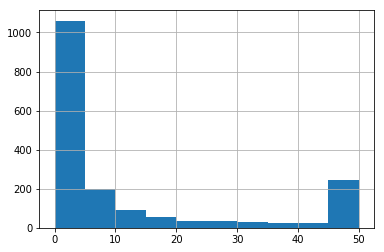

In [68]:
sub_df_de['num_flagged_revisions_pre_treatment'].hist()

In [69]:
sub_df_de.to_pickle('checkpoints/sub_df_de_with_thanks_with_flagged.pickle')

In [70]:
sub_df_de = pd.read_pickle('checkpoints/sub_df_de_with_thanks_with_flagged.pickle')

In [71]:
def make_sessions(ts_list):
    #these structures store the timestamps
    edit_sessions = []
    curr_edit_session = []

    #initialize prev to the earliest data possible
    prev_timestamp = datetime.datetime(year=2001, month=1, day=1)

    for index, ts in enumerate(ts_list):
#         print('index:', index)
        curr_timestamp = ts
        #if curr timestamp within 1 hour of last then append
        if curr_timestamp - prev_timestamp < datetime.timedelta(hours=1):
            curr_edit_session.append(curr_timestamp)
        # else start a new edit session
        else:
            #if there's a pre-existing session save it to the return
            if curr_edit_session:
                edit_sessions.append(curr_edit_session)
            # and start a new session
            curr_edit_session = [curr_timestamp]
        # this is before
        if index < len(ts_list)-1:
            prev_timestamp = curr_timestamp
        # this is the last item save this session too.
        else:
#             print('this is the end')
            edit_sessions.append(curr_edit_session)
        
    return edit_sessions

def labour_hours(ts_list):
    sessions = make_sessions(ts_list)
    total_labour_hours = 0
    for session in sessions:
        if len(session) == 1:
            total_labour_hours += 1
        else:
            session_duration = max(session) - min(session)
            session_seconds = session_duration.seconds
            session_hours = session_seconds / (60*60)
            session_hours += 1 # for this session
            total_labour_hours += session_hours
    return total_labour_hours

def ts_in_week(ts_list, date_start, date_end):
    in_week = []
    for ts in ts_list:
        if ts > date_start and ts <= date_end:
            in_week.append(ts)
    return in_week

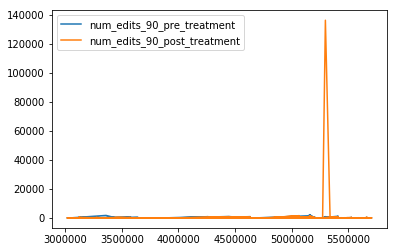

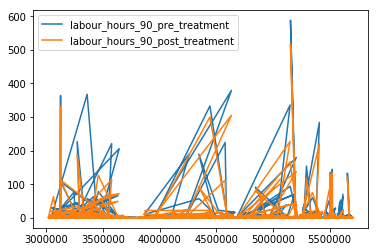

In [72]:
sub_df_de['labour_hours_90_pre_treatment'] = sub_df_de['timestamps_90_before_sim_treatment'].apply(labour_hours)

sub_df_de['num_edits_90_pre_treatment'] = sub_df_de['timestamps_90_before_sim_treatment'].apply(len)

sub_df_de['labour_hours_90_post_treatment'] = sub_df_de['timestamps_90_after_sim_treatment'].apply(labour_hours)

sub_df_de['num_edits_90_post_treatment'] = sub_df_de['timestamps_90_after_sim_treatment'].apply(len)

sub_df_de[['num_edits_90_pre_treatment', 'num_edits_90_post_treatment']].plot()

sub_df_de[['labour_hours_90_pre_treatment', 'labour_hours_90_post_treatment']].plot()

sub_df_de.to_pickle('checkpoints/sub_df_de_revs_ts_labour_hours_1.pickle')

sub_df_de = pd.read_pickle('checkpoints/sub_df_de_revs_ts_labour_hours_1.pickle')

KeyboardInterrupt: 

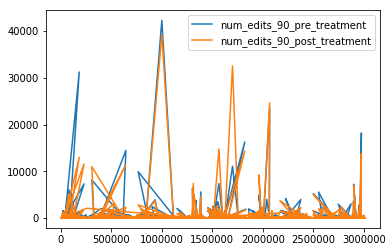

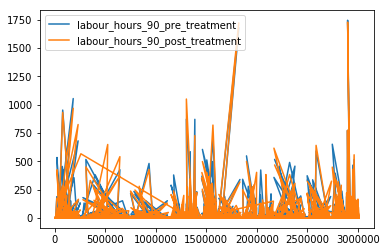

In [73]:
sub_df['labour_hours_90_pre_treatment'] = sub_df['timestamps_90_before_sim_treatment'].apply(labour_hours)

sub_df['num_edits_90_pre_treatment'] = sub_df['timestamps_90_before_sim_treatment'].apply(len)

sub_df['labour_hours_90_post_treatment'] = sub_df['timestamps_90_after_sim_treatment'].apply(labour_hours)

sub_df['num_edits_90_post_treatment'] = sub_df['timestamps_90_after_sim_treatment'].apply(len)

sub_df[['num_edits_90_pre_treatment', 'num_edits_90_post_treatment']].plot()

sub_df[['labour_hours_90_pre_treatment', 'labour_hours_90_post_treatment']].plot()

sub_df.to_pickle('checkpoints/sub_df_revs_ts_labour_hours_1.pickle')

sub_df = pd.read_pickle('checkpoints/sub_df_revs_ts_labour_hours_1.pickle')

inactive = sub_df[sub_df['active_in_90_pre_treatment']==False]
active = sub_df[sub_df['active_in_90_pre_treatment']==True]

active['num_edits_90_pre_treatment'].mean()

active['num_edits_90_post_treatment'].mean()

In [74]:
edit_col_f = 'num_edits_week_{ind}_post_treatment'
anye_col_f = 'any_edits_week_{ind}_post_treatment'
labh_col_f = 'labour_hours_week_{ind}_post_treatment'
anyl_col_f = 'any_labour_hours_week_{ind}_post_treatment'

col_fn ={edit_col_f: len,
         anye_col_f: lambda x: len(x)>0,
         labh_col_f: lambda x: labour_hours(x),
         anyl_col_f: lambda x: labour_hours(x)>0}

sub_df_list = []
try:
    sub_df_list.append(sub_df)
except NameError:
    pass
try:
    sub_df_list.append(sub_df_de)
except NameError:
    pass


for col_f, fn in col_fn.items():
    for ind, (week_n_start, week_n_end) in enumerate(window_seq(range(13))):
        ind = ind+1
        days_after_treat_start = week_n_start * 7 
        days_after_treat_end = week_n_end * 7
        date_start = sim_treatment_date + td(days=days_after_treat_start)
        date_end = sim_treatment_date + td(days=days_after_treat_end)

        col = col_f.format(ind=ind)
        print(col)

        ts_week = f'ts_in_week_{ind}'
        
        for sub_df in sub_df_list:
            sub_df[ts_week] = sub_df['timestamps_90_after_sim_treatment'].apply(lambda x: ts_in_week(x, date_start, date_end))
            sub_df[col] = sub_df[ts_week].apply(fn)


            del sub_df[ts_week]

num_edits_week_1_post_treatment
num_edits_week_2_post_treatment
num_edits_week_3_post_treatment
num_edits_week_4_post_treatment
num_edits_week_5_post_treatment
num_edits_week_6_post_treatment
num_edits_week_7_post_treatment
num_edits_week_8_post_treatment
num_edits_week_9_post_treatment
num_edits_week_10_post_treatment
num_edits_week_11_post_treatment
num_edits_week_12_post_treatment
any_edits_week_1_post_treatment
any_edits_week_2_post_treatment
any_edits_week_3_post_treatment
any_edits_week_4_post_treatment
any_edits_week_5_post_treatment
any_edits_week_6_post_treatment
any_edits_week_7_post_treatment
any_edits_week_8_post_treatment
any_edits_week_9_post_treatment
any_edits_week_10_post_treatment
any_edits_week_11_post_treatment
any_edits_week_12_post_treatment
labor_hours_week_1_post_treatment
labor_hours_week_2_post_treatment
labor_hours_week_3_post_treatment
labor_hours_week_4_post_treatment
labor_hours_week_5_post_treatment
labor_hours_week_6_post_treatment
labor_hours_week_7_pos

In [75]:
sub_df_de.to_pickle('checkpoints/sub_df_de_revs_ts_labour_hours_survival_1.pickle')

In [78]:
sub_df_de.tail()

,user_id,user_registration,first_edit,last_edit,lang,num_prev_thanks_before_treatment,active_in_30_pre_treatment,active_in_90_pre_treatment,experience_level_pre_treatment,timestamps_90_before_sim_treatment,...,any_labour_hours_week_3_post_treatment,any_labour_hours_week_4_post_treatment,any_labour_hours_week_5_post_treatment,any_labour_hours_week_6_post_treatment,any_labour_hours_week_7_post_treatment,any_labour_hours_week_8_post_treatment,any_labour_hours_week_9_post_treatment,any_labour_hours_week_10_post_treatment,any_labour_hours_week_11_post_treatment,any_labour_hours_week_12_post_treatment
5574746,2739292,2017-09-20 11:51:19,2017-09-20 11:59:24,2018-02-06 15:20:40,de,0.0,True,True,bin_90,"[2018-01-25 14:20:48, 2018-01-25 14:21:38, 201...",...,False,False,False,False,False,False,True,False,False,False
5606774,2771681,2017-11-06 11:20:35,2017-11-06 11:36:14,2018-03-02 13:49:52,de,0.0,True,True,bin_90,"[2018-01-01 15:44:44, 2018-01-23 20:38:29, 201...",...,True,False,False,False,False,False,False,False,False,False
5585628,2750297,2017-10-06 20:48:31,2017-10-06 20:53:43,2018-02-25 23:16:04,de,0.0,True,True,bin_90,"[2018-01-07 23:40:46, 2018-01-14 18:45:04, 201...",...,False,False,False,False,False,False,False,False,False,False
5595824,2760580,2017-10-21 10:25:22,2017-10-21 10:42:13,2018-02-25 11:45:25,de,0.0,True,True,bin_90,"[2017-12-29 13:26:00, 2018-02-04 14:28:32, 201...",...,False,False,False,False,False,True,True,False,False,False
5617590,2782552,2017-11-20 19:02:25,2017-11-21 13:40:40,2018-02-26 15:37:22,de,8.0,True,True,bin_90,"[2017-12-06 10:11:13, 2017-12-07 16:52:08, 201...",...,True,False,False,False,False,True,False,False,False,False


In [ ]:
sub_df.to_pickle('checkpoints/sub_df_revs_ts_labour_hours_survival_1.pickle')

In [33]:
sub_df = pd.read_pickle('checkpoints/sub_df_revs_ts_labour_hours_survival_1.pickle')

In [29]:
sub_df.memory_usage().sum().sum()

108196.2

In [79]:
sub_df_de.memory_usage().sum().sum()

608400

In [ ]:
del sub_df['timestamps_90_before_sim_treatment']
del sub_df['timestamps_90_after_sim_treatment']

del sub_df['revisions_before_sim_treatment_50']
del sub_df['len_revs']
del sub_df['ores_damaging_data']
del sub_df['ores_goodfaith_data']

In [ ]:
sub_df.to_csv('outputs/gratitude_power-analysis_dataset_sim_date_{0}_v1.csv'.format(sim_treatment_date.strftime('%Y%m%d')))

In [80]:
sub_df_de.to_csv('outputs/de_gratitude_power-analysis_dataset_sim_date_{0}_v1.csv'.format(sim_treatment_date.strftime('%Y%m%d')))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd64af91358>,
      dtype=object)

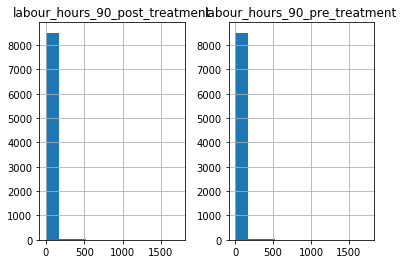

In [34]:
sub_df[['labour_hours_90_pre_treatment','labour_hours_90_post_treatment']].hist()

In [81]:
active = sub_df_de[sub_df_de['active_in_90_pre_treatment']]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd64b289e80>,
      dtype=object)

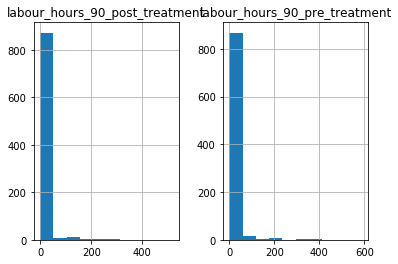

In [82]:
active[['labour_hours_90_pre_treatment','labour_hours_90_post_treatment']].hist()